<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Pix2Struct/Fine_tune_Pix2Struct_on_key_value_pair_dataset_(PyTorch_Lightning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Pix2Struct on a key-value pair dataset

In this notebook, we'll fine-tune Google's [Pix2Struct](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct) model on the [CORD dataset](https://huggingface.co/datasets/naver-clova-ix/cord-v2), in the format in which the Donut authors (Donut is a model very similar to Pix2Struct in terms of architecture) prepared it. See also my [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/DocVQA/Creating_a_toy_DocVQA_dataset_for_Donut.ipynb) regarding preparing a custom dataset in this format.

The goal for the model is to predict a piece of text given a document image.

## Set-up environment

We start by installing 🤗 Transformers and 🤗 Datasets.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.2 MB/s eta 0:00:00


In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.5 MB/s eta 0:00:00


We'll also install PyTorch Lightning and Weights and Biases, as those are the tools we'll use for training.

In [3]:
!pip install -q lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.0/546.0 KB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load dataset

Let's load the dataset from the [hub](https://huggingface.co/datasets/naver-clova-ix/cord-v2).

In [4]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset consists of 3 splits as can be seen: train, validation and test. Each example consists of an "image" and a "ground_truth" string.

In [5]:
dataset

DatasetDict({
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
})

Let's check and visualize the first training example:

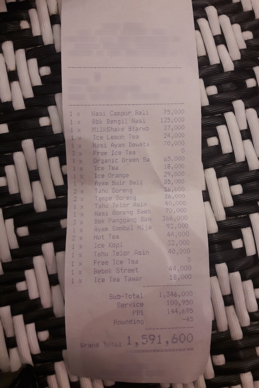

In [6]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [7]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"menu": [{"nm": "Nasi Campur Bali", "cnt": "1 x", "price": "75,000"}, {"nm": "Bbk Bengil Nasi", "cnt": "1 x", "price": "125,000"}, {"nm": "MilkShake Starwb", "cnt": "1 x", "price": "37,000"}, {"nm": "Ice Lemon Tea", "cnt": "1 x", "price": "24,000"}, {"nm": "Nasi Ayam Dewata", "cnt": "1 x", "price": "70,000"}, {"nm": "Free Ice Tea", "cnt": "3 x", "price": "0"}, {"nm": "Organic Green Sa", "cnt": "1 x", "price": "65,000"}, {"nm": "Ice Tea", "cnt": "1 x", "price": "18,000"}, {"nm": "Ice Orange", "cnt": "1 x", "price": "29,000"}, {"nm": "Ayam Suir Bali", "cnt": "1 x", "price": "85,000"}, {"nm": "Tahu Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tempe Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tahu Telor Asin", "cnt": "1 x", "price": "40,000."}, {"nm": "Nasi Goreng Samb", "cnt": "1 x", "price": "70,000"}, {"nm": "Bbk Panggang Sam", "cnt": "3 x", "price": "366,000"}, {"nm": "Ayam Sambal Hija", "cnt": "1 x", "price": "92,000"}, {"nm": "Hot Tea", "cnt": "2 x", "price

Using Python's `literal_eval` function, you can turn it into an actual Python dictionary:

In [8]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': '1 x', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'price': '92,000'},
  {'nm': 'Hot Tea', '

## Load model and processor

Next, let's load the model and its processor from the [hub](https://huggingface.co/models?other=pix2struct). Here we just use the pre-trained only, base-sized model, but note that there are 20 different checkpoints released on the hub.

In [9]:
from transformers import Pix2StructForConditionalGeneration, AutoProcessor

repo_id = "google/pix2struct-base"

processor = AutoProcessor.from_pretrained(repo_id)
model = Pix2StructForConditionalGeneration.from_pretrained(repo_id, is_encoder_decoder=True)

## Create PyTorch dataset

We create a regular PyTorch Dataset class which returns examples of the data, prepared for the model.

In [10]:
import json
import random
from typing import Any, List
from torch.utils.data import Dataset

added_tokens = []

class ImageCaptioningDataset(Dataset):
    def __init__(
        self,
        dataset_name_or_path: str,
        max_patches: int = 1024,
        max_length: int = 512,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.split = split
        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.max_patches = max_patches
        self.max_length = max_length
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.gt_token_sequences = []
        for ground_truth in self.dataset["ground_truth"]:
            ground_truth = json.loads(ground_truth)
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # prepare inputs
        encoding = processor(images=item["image"], max_patches=self.max_patches, return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        
        # prepare targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ).input_ids

        labels = input_ids.squeeze().clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        encoding["labels"] = labels
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return encoding, target_sequence

In [11]:
train_dataset = ImageCaptioningDataset("naver-clova-ix/cord-v2",
                                       split="train", sort_json_key=False) # cord dataset is preprocessed, so no need for this
val_dataset = ImageCaptioningDataset("naver-clova-ix/cord-v2",
                                       split="validation", sort_json_key=False) # cord dataset is preprocessed, so no need for this

In [12]:
encoding, target_sequence = train_dataset[0]
print(encoding.keys())

dict_keys(['flattened_patches', 'attention_mask', 'labels'])


In [13]:
print(processor.decode([id.item() for id in encoding["labels"] if id != -100]))

<s_menu><s_nm> Nasi Campur Bali</s_nm><s_cnt> 1 x</s_cnt><s_price> 75,000</s_price> <sep/><s_nm> Bbk Bengil Nasi</s_nm><s_cnt> 1 x</s_cnt><s_price> 125,000</s_price> <sep/><s_nm> MilkShake Starwb</s_nm><s_cnt> 1 x</s_cnt><s_price> 37,000</s_price> <sep/><s_nm> Ice Lemon Tea</s_nm><s_cnt> 1 x</s_cnt><s_price> 24,000</s_price> <sep/><s_nm> Nasi Ayam Dewata</s_nm><s_cnt> 1 x</s_cnt><s_price> 70,000</s_price> <sep/><s_nm> Free Ice Tea</s_nm><s_cnt> 3 x</s_cnt><s_price> 0</s_price> <sep/><s_nm> Organic Green Sa</s_nm><s_cnt> 1 x</s_cnt><s_price> 65,000</s_price> <sep/><s_nm> Ice Tea</s_nm><s_cnt> 1 x</s_cnt><s_price> 18,000</s_price> <sep/><s_nm> Ice Orange</s_nm><s_cnt> 1 x</s_cnt><s_price> 29,000</s_price> <sep/><s_nm> Ayam Suir Bali</s_nm><s_cnt> 1 x</s_cnt><s_price> 85,000</s_price> <sep/><s_nm> Tahu Goreng</s_nm><s_cnt> 2 x</s_cnt><s_price> 36,000</s_price> <sep/><s_nm> Tempe Goreng</s_nm><s_cnt> 2 x</s_cnt><s_price> 36,000</s_price> <sep/><s_nm> Tahu Telor Asin</s_nm><s_cnt> 1 x</s_cn

In [14]:
print(target_sequence)

<s_menu><s_nm>Nasi Campur Bali</s_nm><s_cnt>1 x</s_cnt><s_price>75,000</s_price><sep/><s_nm>Bbk Bengil Nasi</s_nm><s_cnt>1 x</s_cnt><s_price>125,000</s_price><sep/><s_nm>MilkShake Starwb</s_nm><s_cnt>1 x</s_cnt><s_price>37,000</s_price><sep/><s_nm>Ice Lemon Tea</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><sep/><s_nm>Nasi Ayam Dewata</s_nm><s_cnt>1 x</s_cnt><s_price>70,000</s_price><sep/><s_nm>Free Ice Tea</s_nm><s_cnt>3 x</s_cnt><s_price>0</s_price><sep/><s_nm>Organic Green Sa</s_nm><s_cnt>1 x</s_cnt><s_price>65,000</s_price><sep/><s_nm>Ice Tea</s_nm><s_cnt>1 x</s_cnt><s_price>18,000</s_price><sep/><s_nm>Ice Orange</s_nm><s_cnt>1 x</s_cnt><s_price>29,000</s_price><sep/><s_nm>Ayam Suir Bali</s_nm><s_cnt>1 x</s_cnt><s_price>85,000</s_price><sep/><s_nm>Tahu Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tempe Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tahu Telor Asin</s_nm><s_cnt>1 x</s_cnt><s_price>40,000.</s_price><sep/><s_nm>Nasi Goren

In [15]:
print("Number of added tokens:", len(added_tokens))
print(added_tokens)

Number of added tokens: 54
['<s_menu>', '</s_menu>', '<s_nm>', '</s_nm>', '<s_cnt>', '</s_cnt>', '<s_price>', '</s_price>', '<s_sub_total>', '</s_sub_total>', '<s_subtotal_price>', '</s_subtotal_price>', '<s_service_price>', '</s_service_price>', '<s_tax_price>', '</s_tax_price>', '<s_etc>', '</s_etc>', '<s_total>', '</s_total>', '<s_total_price>', '</s_total_price>', '<s_sub>', '</s_sub>', '<s_cashprice>', '</s_cashprice>', '<s_changeprice>', '</s_changeprice>', '<s_menutype_cnt>', '</s_menutype_cnt>', '<s_menuqty_cnt>', '</s_menuqty_cnt>', '<s_discount_price>', '</s_discount_price>', '<s_unitprice>', '</s_unitprice>', '<s_total_etc>', '</s_total_etc>', '<s_creditcardprice>', '</s_creditcardprice>', '<s_num>', '</s_num>', '<s_discountprice>', '</s_discountprice>', '<s_emoneyprice>', '</s_emoneyprice>', '<s_void_menu>', '</s_void_menu>', '<s_othersvc_price>', '</s_othersvc_price>', '<s_vatyn>', '</s_vatyn>', '<s_itemsubtotal>', '</s_itemsubtotal>']


In [16]:
len(processor.tokenizer)

50398

## Create PyTorch DataLoaders

Next, we create PyTorch DataLoader which allow us to get batches of the data.

In [17]:
from torch.utils.data import DataLoader
import multiprocessing

num_cores = multiprocessing.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_cores)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=num_cores)

In [18]:
# get first batch
batch = next(iter(train_dataloader))
encoding, target_sequences = batch

In [19]:
for k,v in encoding.items():
  print(k,v.shape)

flattened_patches torch.Size([1, 1024, 770])
attention_mask torch.Size([1, 1024])
labels torch.Size([1, 512])


In [20]:
print(processor.batch_decode([id for id in encoding["labels"].squeeze().tolist() if id != -100]))

['<s_menu>', '<s_nm>', 'BLACK', 'PR', 'A', 'WN', 'PAS', 'TA', '</s_nm>', '<s_cnt>', '', '1', '</s_cnt>', '<s_price>', '', '8', '0', ',', '5', '0', '0', '</s_price>', '<', 'sep', '/>', '<s_nm>', 'CAR', 'BO', 'NA', 'RA', '</s_nm>', '<s_cnt>', '', '1', '</s_cnt>', '<s_price>', '', '7', '0', ',', '5', '0', '0', '</s_price>', '<', 'sep', '/>', '<s_nm>', 'EA', 'RL', 'GR', 'EY', 'MIL', 'K', 'TE', 'A', '</s_nm>', '<s_cnt>', '', '1', '</s_cnt>', '<s_price>', '', '5', '7', ',', '0', '0', '0', '</s_price>', '</s_menu>', '<s_sub_total>', '<s_subtotal_price>', '', '2', '0', '8', ',', '0', '0', '0', '</s_subtotal_price>', '<s_service_price>', '', '1', '2', ',', '4', '8', '0', '</s_service_price>', '<s_tax_price>', '', '2', '2', ',', '0', '4', '8', '</s_tax_price>', '</s_sub_total>', '<s_total>', '<s_total_price>', '', '2', '4', '2', ',', '5', '2', '8', '</s_total_price>', '</s_total>', '</s>']


## Define Lighting module

As we'll train the model using [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/), we define a so-called LightningModule, which is an `nn.Module` with additional functionality such that we don't need to take care of device placement etc.

In [29]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import wandb

import torch

from transformers.optimization import Adafactor, get_cosine_schedule_with_warmup

import pytorch_lightning as pl


class Pix2Struct(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        encoding, _ = batch
        
        outputs = self.model(**encoding)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        encoding, answers = batch
        flattened_patches, attention_mask = encoding["flattened_patches"], encoding["attention_mask"]
        batch_size = flattened_patches.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.text_config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(flattened_patches=flattened_patches,
                                      attention_mask=attention_mask,
                                      # decoder_input_ids=decoder_input_ids,
                                      max_new_tokens=512,
                                      return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            # seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            # pred = re.sub(r"(?:(?<=>) | (?=", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))
            
            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores)) 
        
        return scores

    def configure_optimizers(self):
        optimizer = Adafactor(self.parameters(), scale_parameter=False, relative_step=False, lr=self.config.get("lr"), weight_decay=1e-05)
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.config.get("num_warmup_steps"),
                                                    num_training_steps=self.config.get("max_steps"))
        
        return [optimizer], [scheduler]

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train!

Next, we instantiate the model and define a PyTorch Lightning Trainer. We can specify all kinds of things, such as on which devices we'd like to train, whether to use gradient clipping, logging to Weights and Biases etc. Check the [docs](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html#lightning.pytorch.trainer.trainer.Trainer) for all arguments you can pass to the Trainer - there are a lot of them!

Note: the model seems to converge **much slower** than Donut on this dataset. This may be due to a domain shift: Pix2Struct has been pre-trained on web page images (by predicting HTML on masked image portions). I haven't played too much with hyperparameters, I'm using the Adam optimizer with learning rate 1e-5. For reference, the authors use the AdaFactor optimizer with weight decay rate of 1e-5, with a learning rate that starts with 0.001 and goes up linearly to 0.01 for 1K steps and then a cosine decay for the rest of the training.

Update: upgraded the notebook to use Adafactor with cosine decay learning rate schedule. Seeing faster (but still pretty slow) convergence.

If you find hyperparameters with great convergence, please share them by opening an issue on my [Transformers-Tutorials](https://github.com/NielsRogge/Transformers-Tutorials) repository.

In [30]:
config = {
          "num_warmup_steps": 1000,
          "max_steps": 30000,
          "lr": 0.01,
          "check_val_every_n_epoch": 5,
          "gradient_clip_val": 1.0,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "accumulate_grad_batches": 8,
          "verbose": True,
          }

pl_module = Pix2Struct(config, processor, model)

In [31]:
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

wandb.finish()
wandb_logger = WandbLogger(project="Pix2Struct", name="demo-run-pix2struct-adafactor")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_steps=config.get("max_steps"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"), # use gradient clipping
        accumulate_grad_batches=config.get("accumulate_grad_batches"), # use gradient accumulation
        logger=wandb_logger,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(pl_module)

## Inference

After training, you can load the model by getting the `pl_module.model` attribute from the PyTorch Ligthing module above (which returns the HuggingFace model). Then you can call either `save_pretrained` or `push_to_hub` on that object, and reload it back using `from_pretrained`. Refer to the [docs](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct#transformers.Pix2StructForConditionalGeneration) regarding inference code examples.